## Flight Rescheduling as a Search Problem

In this notebook, we develop an algorithm that helps some a flight rescheduling problem. This refers to the question of how to best reschedule all future flights from the time of service disruption. In short, the output should be a table, where each line represents a new time for a given flight.

The following assumptions are made:
* $n\_runway$ are available at each time slot of duration $time\_slot\_duration$.
* Each scheduled flight should be assigned a time slot.
* If no time slot can be assigned in a reasonable time, the flight should be diverted.
* The next flight after the last flight in the existing schedule is significiantly later than last scheduled flight.
* Flight will only be assign a time slot equivalent to the original schedule or later.


In this notebook, the terms "cost function" and "objective function" maybe  used interchangeably. Note that each component of *cost* computed in this notebook has a domain of $(-\infty,0)$


In [1]:
# import the necessary packages
import pandas as pd
import numpy as np
import sys
import itertools
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# load the data
df = pd.read_csv("./data/21DEC2023_AMS_processed.csv", parse_dates=['time_sch', 'time_act'])
df.tail(5)

,time_sch,time_act,code,dest,stat,orig,pass_load,time_diff
1195,2023-12-21 23:25:00,2023-12-22 00:21:00,KL 1608 KLM,Amsterdam,BAGGAGE ON BELT,Rome (FCO),309,-83040.0
1196,2023-12-21 23:30:00,2023-12-22 00:29:00,HV 5806 Transavia,Amsterdam,BAGGAGE ON BELT,Thessaloniki (SKG),310,-82860.0
1197,2023-12-21 23:40:00,2023-12-22 00:27:00,HV 6902 Transavia,Amsterdam,BAGGAGE ON BELT,Dubai International (DXB),316,-83580.0
1198,2023-12-21 23:50:00,2023-12-22 00:52:00,HV 5666 Transavia,Amsterdam,BAGGAGE ON BELT,Las Palmas de Gran Canaria (LPA),347,-82680.0
1199,2023-12-21 23:55:00,2023-12-22 01:00:00,HV 5218 Transavia,Amsterdam,BAGGAGE ON BELT,Catania (CTA),304,-82500.0


## Formulate the Problem as a Tree

While we can consider assigning each flight with a time slot, this is also equivalent to a the converse where we assign to each time slot a flight. As such, we can represent this problem in a tree diagram where an increment of tree depth represents the successive time slot. Note that in the general case, the each time slot can be assigned to one or more flight(s), depending on the parameter $n\_runway$.
 
We will consider the general case where the class `problem` initialises with the following attributes that can be customized for any specific flight re-scheduling problem:
* n-runway
* time of operation resumption (hour and minute)
* maximum delay of each flight
* duration of each time slot

Since each flight is only given one time slot, and the problem set up keeps track the schedule as additional flights are assigned a new time slot, this problem set-up can be represented (theoretically) as a well-behaved (acyclic) tree.
![Figure X](./treegraph.png)
*Figure X* is a graphical representation of the tree diagram when n_runway = 1 and each time slot is 5 mins long.


To account for flights having to divert, we the state as a `pd.DataFrame` with columns `time_new`. If the flight has to be diverted, the timeslot assigned would equate to `pd.to_datetime(0)`


In [3]:
class reschedule_problem:

    def __init__(self,df, n_runway = 1, resume_hour = 23, resume_min = 0,\
                timeslot_dur = 5, max_delay = 120):
        # customized attributes of the problem
        self.df = df
        self.move = df['code']
        self.n_runway = n_runway
        self.hour = resume_hour 
        self.min = resume_min 
        self.time_slot_duration = timeslot_dur
        self.max_delay = max_delay
        # parsing the attribute for more useful format
        self.date = self.df.loc[0,'time_sch'].day
        self.month = self.df.loc[0,'time_sch'].month
        self.year = self.df.loc[0,'time_sch'].year
        self.initial = pd.DataFrame(columns = ["time_new","util"], index= []) # to store the solution
        self.solution = None

    def actions(self, state):
        """return a list of n_runway flight(s) that has/have is expected to land
        and is not assigned a time slot under the state"""
        # get the list of unassigned flight where the time_sch is (over)due under current time slot 
        assigned_flight = list([flight for flight in state.index])
        unassigned_flight = self.df.query("code not in @assigned_flight").copy()
        # subset the flights that are not in time yet
        year, month, date, hour, min = self.parse_state_time(state)
        current_time = pd.to_datetime(f"{year} {month} {date} {hour}:{min}")
        min_time = pd.to_datetime(f"{year} {month} {date} {hour}:{min}") - pd.Timedelta(minutes = self.max_delay)
        unassigned_flight['divert'] = unassigned_flight.apply(lambda flight: flight['time_sch'] < min_time  ,axis = 1)
        unassigned_flight['to_sch'] = unassigned_flight.apply(lambda flight: flight['time_sch'] <=current_time  ,axis = 1)

        # return the pd.Series of unassigned flight that has passed its schedule time
        flight_to_assign = unassigned_flight[unassigned_flight['to_sch'] & ~(unassigned_flight['divert'])]['code']
        # return the combination of flights (namely when n_runway > 1)
        flight_to_assign = [comb for n in range(1, self.n_runway+1) for comb in itertools.combinations(flight_to_assign, n)]
        # flight to divert
        flight_diverted = unassigned_flight[unassigned_flight['divert']]['code']
        
        return flight_to_assign, flight_diverted # pd.Series
        
    def parse_state_time(self,state):
        """Use to get the value in the schedule and 
        parse the time of the next time slot"""
        if len(state) <=0: 
            year = self.year
            month = self.month
            date = self.date
            hour = self.hour
            min = self.min

        else:
            timestr = state['time_new'].iloc[-1] # get the time_sch
            year, month, date, time = timestr.split(" ")
            hour , min = time.split(":")
            # get the current time
            min = int(min)
            min += self.time_slot_duration
            if min // 60 <= 1:
                hour = int(hour) + min // 60
                min = min % 60
                if hour // 24 <= 1:
                    date = int(date) + hour // 24
                    hour = hour % 24
                
        return year, month, date, hour,min
    
    def result(self, state, flight_diverted:list, flights:list):
        """return the state in a form of dictionary that is the result of a given move"""
        # !!! think of a way to iterate through the time slot even if no flight assigned
        year, month, date, hour, min = self.parse_state_time(state)
        for fl in flights:
            time_sch = f"{year} {month} {date} {hour:02d}:{min:02d}"
            # get the utility
            util = self.compute_util(fl, year, month, date, hour, min)
            # print(f"Scheudling {flights} for {time_sch}")
            state.loc[fl] = [time_sch, util]
    
        # add the diverted flight into the state
        for fl in flight_diverted:
            util = self.compute_util(fl,1970, 0,0,0,0)
            state.loc[fl] = ["1970 01 01 00:00", util]
            # print(f"Diverting {flights}")

        state = state.sort_values("time_new")

        return state # pd.DataFrame
    
    def compute_util(self, flcode, year, month, date, hour, min):
        """Compute the utility of a given rescheduled flight. This is defined
        as the time difference between the original scheduled time and the 
        new scheduled time"""
        if flcode is None:
            return 0 
        elif year != 1970:
            time_sch_org = self.df.query("code == @flcode")['time_sch'] # type pd Series
            time_sch_new = pd.to_datetime(f"{year} {month} {date} {hour}:{min}")
            # compute the time delayed
            delay = time_sch_org - time_sch_new
            delay = delay.reset_index(drop = True)[0].total_seconds() / 60
            return delay
        elif year == 1970:
            # compute utility of diverted flight
            delay = - self.max_delay 
            return delay
    
    def utility(self, state):
        """Compute aggregate utility of a given state"""
        agg_util = state['util'].sum()
        return agg_util
        
    def goal_test(self, state):
        "return True if the state is terminal"
        flight_assigned = [flight for flight in state.index] 
        if len(flight_assigned) == len(self.df):
        # !!! this is not a robust way since time slot can be none
            return True
        
    def solve(self, solver_algo):
        self.solution = solver_algo(self)    
        
    def display(self):
        """ [in DEV] Method to show the new schedule of the flightafter solving for the problem, 
        """
        if self.solution is None:
            print("The problem has not been solved. Pass a solving algorithm to the .solve method")
            raise NotImplementedError
        
        display_df = self.df.copy()
        display_df = pd.merge(self.df[['code','time_sch','pass_load']], self.solution, left_on= "code", right_index = True)
        display_df['time_new'] = pd.to_datetime(display_df['time_new'])
        display_df['time_dff'] = display_df.apply(lambda x: (x['time_sch'] - x['time_new']).total_seconds()/ 60,axis = 1 )
        display_df['time_dff'] = display_df['time_dff'].apply(lambda x: -x if x <= 0 else "diverted" )
        return display_df


### Node
Recall that at each node, the state it represents is the new schedule up to that time slot.


In [4]:
class Node:
    """This refenece to the anima class node"""
    def __init__(self, state,parent = None, action = None, path_cost = 0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0 
        if parent:
            self.depth = parent.depth + 1
    def __repr__(self):
        """define printing output of the class type"""
        return "<Node of depth {}>".format(self.depth)
    
    def __lt__(self, node):
        """Compare the depth of the nodes -- for use in 
        sorting the *frontier*"""
        return self.depth < node.depth
    
    def expand(self, problem):
        """reach the nodes reachable"""
        flight_to_assign, flight_diverted = problem.actions(self.state)
        return [self.child_node(problem, action, flight_diverted) 
                  for action in flight_to_assign]

    def child_node(self, problem,action, flight_diverted):
        """ Return a Node object representing the child node        
        """
        parent_state = self.state.copy()
        next_state = problem.result(parent_state, flight_diverted, action)
        # print(next_state)
        next_node = Node(next_state, parent=self, action = action, path_cost = problem.utility(next_state))
        return next_node # node object

    

## Uniform-Cost Search
To find the evaluate the for the best schedule, we minimise (the absolute value of) `path_cost` of the node. By construct of the class `Node`, the path cost is the aggregate time delayed (in minutes).

In [5]:
def best_first_graph_search(problem):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""

    # caching values on each node
    # adding first node
    node = Node(problem.initial)
    print(f"The airport resumed service at {problem.hour}:{problem.min:02d}")
    iterations = 1
    # applying the goal test when generating the node
    if problem.goal_test(node.state):
        return(iterations, node)

    # expand the frontier based on the priority queue
    # the current best candidate for extension
    frontier = list()
    frontier.append(tuple([node.path_cost,node ]))
    # append the generated node to the frontier
    # print(f"Exploring depth {node.depth}")
    # print(f"[BFS Chunk] Length of frontier:{len(frontier)}")

    while frontier:
        # get the next node in the frontier
        node = frontier.pop()[1]

        # applying the goal test when expanding the node
        if problem.goal_test(node.state):
            return node.state

        # add explored node to the liss: This is implicit in the set up
        # explored.add(node.state)
        # for every child in the frontier
        for child in node.expand(problem): # child is a node
            # print(f"Exploring depth {node.depth}")
            # print(f"[BFS Chunk]Considering action {child.action}")
            # print(f"Adding child of path cost {child.path_cost} to frontier")
            # print(type(child))
            frontier.append(tuple([int(child.path_cost),child]))
            # print(frontier)
            frontier.sort(reverse = True)
        
    return None
    

## Test the Algorithm

In [6]:
df_subset = df.tail(50).reset_index(drop = True)
resumption = df_subset.iloc[0,0] + pd.Timedelta(minutes = 60)
# initate the problem
AMS_21_tail50 = reschedule_problem(df = df_subset, n_runway=2,
                                   resume_hour= resumption.hour, resume_min=resumption.minute,
                                   max_delay = 60)
# solve the problem
# solution = best_first_graph_search(AMS_21_tail10)
AMS_21_tail50.solve(best_first_graph_search)
AMS_21_tail50.display()


The airport resumed service at 22:20


,code,time_sch,pass_load,time_new,util,time_dff
0,KL 1634 KLM,2023-12-21 21:20:00,241,2023-12-21 22:20:00,-60.0,60.0
1,KL 939 KLM,2023-12-21 21:25:00,252,2023-12-21 22:25:00,-60.0,60.0
2,KL 1481 KLM,2023-12-21 21:25:00,346,2023-12-21 22:25:00,-60.0,60.0
3,KL 1749 KLM,2023-12-21 21:25:00,306,2023-12-21 22:20:00,-55.0,55.0
4,BR 76 EVA Air,2023-12-21 21:30:00,276,2023-12-21 22:30:00,-60.0,60.0
5,KL 1275 KLM,2023-12-21 21:30:00,217,2023-12-21 22:30:00,-60.0,60.0
6,VY 8436 Vueling,2023-12-21 21:35:00,267,2023-12-21 22:35:00,-60.0,60.0
7,HV 6146 Transavia,2023-12-21 21:40:00,320,2023-12-21 22:40:00,-60.0,60.0
8,EJU 7844 easyJet Europe,2023-12-21 21:40:00,233,2023-12-21 22:35:00,-55.0,55.0
9,KL 1368 KLM,2023-12-21 21:45:00,344,2023-12-21 22:45:00,-60.0,60.0


Analysis:
While this is similar to the map search problem discussed in *Artificial Intelligence: A Modern Approach*, this does not always return the optimal solution.

(need more time to formulate but here is the rough idea):
In this rescheduling method, each node is mapped to one (and only one) state. However, in the routing problem, a state can be mapped to different nodes. There is only one sate that is terminal.

In this algorithm, however, it will return the solution as long as it reaches a terminal state, and there are more than one terminal state.

### Alternative Utility Function
In the above algorithm we simply used the time delayed as the utility of each assignment of time slot. From the airport point of view, the amount of passeneger passing through the airport smoothly should be considered in the objective function. The same can be said for the passengers' point of view. In addition, we may also discount the utility of the future nodes as the further away from the the current time, there is higher uncertainty. We could scale the time delay using a diminishing weight by passenger load.

Recall that the passenger load is a simulated data set that follows a normal distribution:
$$pass\_load ~ N(\mu= 300,\sigma^2=50^2)$$

The utility of each node is an additive function of all the individual time delayed (in minute) for each rescheduled flight calculated as:
$$\max(time\_sch - time\_new, max\_delay)$$

Note that it takes a range of $(max\_delay,0)$, we can rescale with a function of passenger that increases at a decreasing scale. A proposed scale:
$$\arctan(\frac{pass\_load}{100})\frac{2}{\pi}$$

With this function, it is more costly to delay a flight with more passenger than one with less if their originaly scheduled time is the same.


In [7]:
pass_load = np.random.normal(3,0.5,size = 1000)
time_delay = -10 # in minutes
cost = time_delay * np.arctan(pass_load) / (np.pi/2)

Text(0.5, 1.0, 'Cost function in relation to Passenger Load')

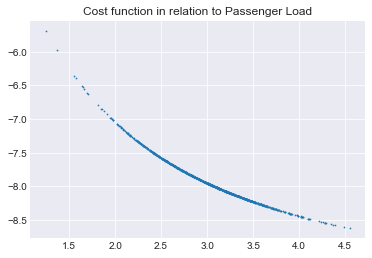

In [8]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots() 
ax.scatter(pass_load, cost, 0.5)
ax.set_title("Cost function in relation to Passenger Load")
#ax.set_axis_off()

To make this modification, we can simply inherit the properties of the `reschedule_problem` and overwrite the `compute_util` method.

In [9]:
class reschedule_updated_u(reschedule_problem):

    def __init__(self, df, n_runway = 1, resume_hour = 23, resume_min = 0,
                timeslot_dur = 5, max_delay = 120):
        super().__init__(df, n_runway , resume_hour , resume_min,
                timeslot_dur, max_delay)


    def compute_util(self, flcode, year, month, date, hour, min):
        """Compute the utility of a given rescheduled flight. This is defined
        as the time difference between the original scheduled time and the 
        new scheduled time"""
        if flcode is None:
            return 0 
        elif year != 1970:
            time_sch_org = self.df.query("code == @flcode")['time_sch'] # type pd Series
            time_sch_new = pd.to_datetime(f"{year} {month} {date} {hour}:{min}")
            # compute the time delayed
            delay = time_sch_org - time_sch_new
            delay = delay.reset_index(drop = True)[0].total_seconds() / 60

        elif year == 1970:
            # compute utility of diverted flight
            delay = - self.max_delay 

        pass_load = self.df.query("code == @flcode")['pass_load'].values
        util = delay * np.arctan(pass_load/4) /np.pi * 2

        return util[0]


Using the same set up as we did with the previous question, we test for the result.

In [10]:
# initate the problem
AMS_21_tail50_2 = reschedule_updated_u(df = df_subset, n_runway=2,
                                   resume_hour= resumption.hour, resume_min=resumption.minute,
                                   max_delay = 60)
# solve the problem
AMS_21_tail50_2.solve(best_first_graph_search)
AMS_21_tail50_2.display()

The airport resumed service at 22:20


,code,time_sch,pass_load,time_new,util,time_dff
0,KL 1634 KLM,2023-12-21 21:20:00,241,2023-12-21 22:20:00,-59.366080,60.0
1,KL 939 KLM,2023-12-21 21:25:00,252,2023-12-21 22:25:00,-59.393746,60.0
2,KL 1481 KLM,2023-12-21 21:25:00,346,2023-12-21 22:25:00,-59.558434,60.0
3,KL 1749 KLM,2023-12-21 21:25:00,306,2023-12-21 22:20:00,-54.542326,55.0
4,BR 76 EVA Air,2023-12-21 21:30:00,276,2023-12-21 22:30:00,-59.446456,60.0
5,KL 1275 KLM,2023-12-21 21:30:00,217,2023-12-21 22:30:00,-59.295984,60.0
6,VY 8436 Vueling,2023-12-21 21:35:00,267,2023-12-21 22:35:00,-59.427800,60.0
7,HV 6146 Transavia,2023-12-21 21:40:00,320,2023-12-21 22:40:00,-59.522560,60.0
8,EJU 7844 easyJet Europe,2023-12-21 21:40:00,233,2023-12-21 22:35:00,-54.398959,55.0
9,KL 1368 KLM,2023-12-21 21:45:00,344,2023-12-21 22:45:00,-59.555867,60.0


Looking at the result, it seems that this new way of utility function does not change have any impact of the solution given by the algorithm.

## Heuristic Search